# RetinaMNIST with rotations

In this exercise your goal will be to solve an object detection training and prediction task using the anchor-based approach.
**As a part of your solution you should provide a report summarizing your findings and results of the conducted experiments.**

##TLDR; overview

In this task one should:
- determine the size of the feasible anchors for the object detection task posed in this Assignment,
- build an object detection model using the variant of `RetinaNet`,
- prepare a matching suite which will match predicted anchors with ground truth bounding boxes,
- train an object detection model using a variant of `RetinaLoss`.

Hints and comments:

- Model architecture and loss are heavily inspired by [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) paper,
- you can freely subclass and extend the interface of classes in this exercise,
- be sure that you understand the concept of an anchor for object detection, covered during the lecture about Object Detection. There are many great tutorials and articles about it (e.g. [this](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) one, note however that we are not implementing ignoring boxes for simplicity).

### Data description

In this task we will paste bounding boxes with digits **from 1 to 5** randomly selected from `MNIST` dataset on a canvas of size `(128, 128)` and **randomly flipped by 90 degrees**. We assume that:

- the two boxes from a canvas should have no more than `0.1` of `iou` overlap,
- the digits are fully contained in canvas,
- boxes are modeled using `MnistBox` class,
- canvas is modeled using `MnistCanvas` class.

Let us have a look at definition of these classes:

In [ ]:
from typing import List
from typing import Optional
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MnistBox:

    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
        rotated: Optional[bool] = None,
    ):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.class_nb = class_nb
        self.rotated = rotated
    
    @property
    def x_diff(self):
        return self.x_max - self.x_min
    
    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}.' +\
               f' Rotated = {self.rotated}.'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        ax.add_patch(
            patches.Rectangle(
                (self.y_min, self.x_min),
                 self.y_diff,
                 self.x_diff,
                 linewidth=1,
                 edgecolor=color,
                 facecolor='none',
            )
        )
        ax.text(
            self.y_min,
            self.x_min,
            f'{self.class_nb}' if not self.rotated else f'{self.class_nb}*',
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        ) 
        return aux_box.area / (self.area + other_box.area - aux_box.area)


class MnistCanvas:

    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        rotated=None,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]:
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
            class_nb=class_nb,
            rotated=rotated,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        ) 
        return True
        
    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        boxes = boxes or self.boxes
        for box in boxes:
            box.plot_on_ax(ax)
        plt.show()

Each canvas has 3-6 boxes with randomly selected digits. The digits for training data are from first 10K examples from `MNIST` train data. The digits for test data are selected from first 1K examples from `MNIST` test data. The Dataset is generated using the following functions:

In [ ]:
from keras.datasets import mnist
import numpy as np


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)
    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit_class = classes[current_digit_index]
        if current_digit_class not in [1, 2, 3, 4, 5]:
            continue
        rotate = np.random.random() > 0.5
        current_digit = digits[current_digit_index]
        if rotate:
            current_digit = np.rot90(current_digit)
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min,
            y_min=random_y_min,
            class_nb=current_digit_class,
            rotated=rotate,
        ):
            attempts_done += 1
    return new_canvas

Let us have a look at example canvas (rotated digits have additional *added to description).

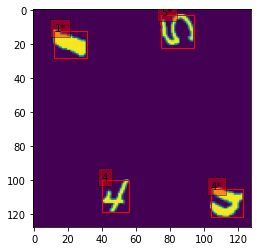

In [ ]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()

Now - let us generate test canvas:

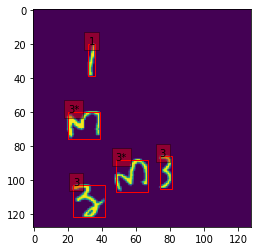

In [ ]:
TEST_CANVAS_SIZE = 256
TEST_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TEST_SEED)

TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

TEST_CANVAS[0].plot()

For training one can either:
- generate `TRAIN_CANVAS` similarly to `TEST_CANVAS` creation,
- use the fact that `get_random_canvas()` generates a random train canvas and generate training data on-the-fly.

### Anchor size analysis (2pts)

For this task:
1. Sample at least 1000 random canvas.
2. Analyze the sizes (heights and widths) of the `MnistBox`es from this canvas.
3. Select the anchor sizes which will match the problem the best.

Selected anchor sizes should be stored in a sensible manner in `ANCHOR_SIZES` list.

## Solution

I thought that it may be a good idea to look at a heatmap of the anchor sizes.

In [ ]:
NUM_CANVASES = 1000

canvases = [get_random_canvas(digits=TRAIN_DIGITS, classes=TRAIN_CLASSES)
            for _ in range(NUM_CANVASES)]
boxes = [box for canvas in canvases for box in canvas.boxes]
box_sizes = np.array([[box.x_diff, box.y_diff] for box in boxes])

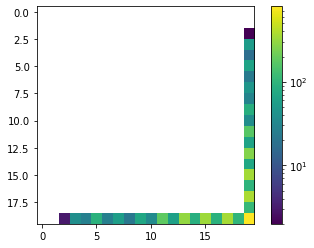

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

x_max, y_max = np.amax(box_sizes, axis=0)
counter = np.zeros((x_max+1, y_max+1), dtype=int)
np.add.at(counter, (box_sizes[:,0], box_sizes[:,1]), 1)

plt.imshow(counter, norm=LogNorm())
plt.colorbar()

In [ ]:
all(x == 19 or y == 19 for x, y in box_sizes)

True

It would indeed seem that at least one of the coordinates is equal to $19$; I would therefore say that the appropriate anchor sizes are $(x, 19)$ for odd $x \in \{x_{\min}, \ldots, x_{\max}\}$ and likewise $(19, y)$ (the "odd" part is to make it easier to produce the anchors, and besides it reduces the number of them by 2x). I will also make it a bit more sparse in the low end since there aren't that many box sizes there, as is clear from the heatmap.

In [ ]:
x_min, y_min = np.amin(box_sizes, axis=0)
print(x_min, x_max, y_min, y_max)

values = [3, 7, 11, 13, 15, 17, 19]
ANCHOR_SIZES = [*((x, 19) for x in values), 
                *((19, y) for y in values)]
ANCHOR_SIZES

2 19 2 19


[(3, 19),
 (7, 19),
 (11, 19),
 (13, 19),
 (15, 19),
 (17, 19),
 (19, 19),
 (19, 3),
 (19, 7),
 (19, 11),
 (19, 13),
 (19, 15),
 (19, 17),
 (19, 19)]

### Model building (2pt)


One should build a model for digit detection in $\texttt{pytorch}$. Model should consist of:

#### $\texttt{backbone}$:

We provided you with a backbone model architecture that accepts a `MnistCanvas` instance and output a tensor with shape $(1, 16, 16, 128)$. It should be trained together with the rest of your solution.

#### $\texttt{anchors}$:

List of `MnistBox`es where each box:

- should have size of one of selected `ANCHOR_SIZES`,
- should have center coordinates on canvas of type $\left(\left(m + \frac{1}{2}\right) * 8, \left(n + \frac{1}{2}\right) * 8\right)$  for $m, n \in \{0, 1, \dots, 16 - 1\}$,

`MnistBox` with anchor should have an attribute `class_nb` set to `None`.

#### $\texttt{digitClassificationHead}$:

$\texttt{digitClassificationHead}$ should accept backbone output as an input and output `digit_classification_output` tensor of shape $(len(\texttt{anchors)}, 5)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit of class $j + 1$ (ground truth box).

#### $\texttt{rotationClassificationHead}$:

$\texttt{rotationClassificationHead}$ should accept backbone output as an input and output `rotation_classification_output` tensor of shape $(len(\texttt{anchors)}, 2)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit which was not rotated when $j = 0$ and was rotated when $j = 1$.

#### $\texttt{boxRegressionHead}$:

$\texttt{boxRegressionHead}$ should accept backbone output as an input and output `box_regression_output` tensor of shape $(len(\texttt{anchors)}, 4)$ where the value $br_{i}$ which is the value of i-th row has a property that if there is a ground truth digit box $\texttt{GTBox}$ - significantly overlapping with $\texttt{anchor}[i]$ then the following properties hold:

$$\texttt{GTBox.x_min} = \texttt{anchor[i].x_min} + br_{i, 0},$$ 
$$\texttt{GTBox.x_max} = \texttt{anchor[i].x_max} + br_{i, 1},$$ 
$$\texttt{GTBox.y_min} = \texttt{anchor[i].y_min} + br_{i, 2},$$ 
$$\texttt{GTBox.y_max} = \texttt{anchor[i].y_max} + br_{i, 3}.$$ 

#### *Hint*: be careful with a construction of a head output as a simple reshaping might cause unexpected permutation of anchors.

### Model output

Model should output `DigitDetectionModelOutput` class defined below.

#### Comment on _significant overlap_:

The meaning of significant overlap will be described later.

## Solution

Let's start with the anchors. I will clip some of them, so not all the centers will be as specified in the text above, but I hope it's not a major issue.

In [ ]:
def make_box(m, n, x, y):
  x_min = np.clip(8*m+4-x//2, 0, 128-1)
  x_max = np.clip(8*m+4+x//2, 0, 128-1)
  y_min = np.clip(8*n+4-y//2, 0, 128-1)
  y_max = np.clip(8*n+4+y//2, 0, 128-1)
  return MnistBox(x_min, y_min, x_max, y_max)

ms, ns = np.indices((16, 16))
ANCHORS = np.array([[make_box(ms[idx], ns[idx], x, y)
                     for x, y in ANCHOR_SIZES]
                    for idx in np.ndindex(*ms.shape)])
ANCHORS = ANCHORS.reshape((-1))

All the `MaxPool`ing in the backbone makes it so that the 16x16 "image" produced by it roughly corresponds to the anchor centers that we want (in any case, that's what we shall assume since it makes it easier). Then, insofar as the heads are concerned, we just use a `Conv2d` from the output # of channels from the backbone to 5, 2, 4 channels for the heads respectively, with a kernel size of 1 since we don't want to pool anything at this stage but rather just reduce it all, sort of like a bunch of fully-connected layers for each of the segments. Finally we flatten the tensors in the same fashion as we do the `ANCHORS`, so that we end up with the correct order of anchors (hopefully).

In [ ]:
from torch import nn



class DigitDetectionModelOutput:
    def __init__(
        self,
        anchors: List[MnistBox],
        digit_classification_output: torch.Tensor,
        rotation_classification_output: torch.Tensor,
        box_regression_output: torch.Tensor,
    ):
        self.anchors = anchors
        self.digit_classification_output = digit_classification_output
        self.box_regression_output = box_regression_output
        self.rotation_classification_output = rotation_classification_output


class Backbone(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.output_shape = (16, 16, 128)
        self.first_block = torch.nn.Sequential(
            nn.Conv2d(1, 16, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.blocks = torch.nn.ModuleList(
            [torch.nn.Sequential(*[
                nn.Conv2d(16 * (2 ** i), 16 * (2 ** (i + 1)), (3, 3), padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
              ]) for i in range(1, 3)
            ]
        )

    def forward(self, x: MnistCanvas) -> torch.Tensor:
        image = torch.Tensor(x.image).to(DEVICE).view(1, 1, 128, 128)
        aux = self.first_block(image)
        for block in self.blocks:
            aux = block(aux)
        return aux


class DigitDetectionModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.backbone = Backbone()
    self.num_anchors = len(ANCHOR_SIZES)

    def create_head(out_channels, classifier=True):
      final_conv = nn.Conv2d(128, out_channels, 1)
      if classifier:
        def_prob = 1e-2
        final_conv.bias.data.fill_(-np.log((1-def_prob)/def_prob))
      
      return torch.nn.Sequential(
        nn.Conv2d(128, 128, 3, padding=1),
        nn.ReLU(True),
        nn.Conv2d(128, 128, 3, padding=1),
        nn.ReLU(True),
        nn.Conv2d(128, 128, 3, padding=1),
        nn.ReLU(True),
        final_conv
      )

    self.digit_pred_head = create_head(5*self.num_anchors)
    self.rot_pred_head = create_head(2*self.num_anchors)
    self.box_regr_head = create_head(4*self.num_anchors, classifier=False)

  def forward(self, x: MnistCanvas) -> DigitDetectionModelOutput:
    x = self.backbone(x)

    anchors = ANCHORS

    digit_pred = self.digit_pred_head(x)
    digit_pred = digit_pred.permute((0, 2, 3, 1)).reshape((len(anchors), 5))

    rot_pred = self.rot_pred_head(x)
    rot_pred = rot_pred.permute((0, 2, 3, 1)).reshape((len(anchors), 2))

    box_regr = self.box_regr_head(x)
    box_regr = box_regr.permute((0, 2, 3, 1)).reshape((len(anchors), 4))

    return DigitDetectionModelOutput(ANCHORS, digit_pred, rot_pred, box_regr)

### Significant overlap (4pt)

In order to manage definition of a _significant overlap_ student should implement the `TargetDecoder`. `TargetDecoder` have two methods:

### - `get_targets`

This method accepts a `canvas: MnistCanvas` with boxes later refered to as `gt_boxes: List[MnistBox]`, `anchors: List[MnistBox]` of model anchors and `iou_threshold: float`. Its output should be `DigitDetectionModelTarget` instance with the following attributes:

- `digit_classification_target` - a tensor of shape $(len(anchors), 5)$,
- `rotation_classification_target` - a tensor of shape $(len(anchors), 2)$
- `box_regression_target` - a tensor of shape $(len(anchors), 4)$,
- `matched_anchors` - a list of indices anchors matched (see definition below).

The output attributes should be computed in a following manner: 

1. All of the outputs of the output tensors should be `0` except the case presented in the point 2.
1. if for anchor `anchors[i]` there exist at least one `gt_box` from `gt_boxes` with `iou` overlap greater than `iou_threshold` then let `gt_best` be the one with the greatest `iou` overlap (ties resolved randomly). Then `box_regression_target` should encode the bounding box correction, namely:

$$\texttt{box_regression_target}[i, 0] = \texttt{gt_best.x_min} - \texttt{anchor[i].x_min}$$ 
$$\texttt{box_regression_target}[i, 1] = \texttt{gt_best.x_max} - \texttt{anchor[i].x_max}$$ 
$$\texttt{box_regression_target}[i, 2] = \texttt{gt_best.y_min} - \texttt{anchor[i].y_min}$$ 
$$\texttt{box_regression_target}[i, 3] = \texttt{gt_best.y_max} - \texttt{anchor[i].y_max}$$,

`digit_classification_target` should encode the class of matched `gt_best`, namely:

$$\texttt{digit_classification_target}[i, \texttt{gt_best.class_nb} - 1] = 1.$$

`rotation_classification_target` should encode if matched `gt_best` has a digit which was rotated, namely:

$$\texttt{rotation_classification_target}[i, 0] = 1,$$

if `gt_best` digit was not rotated and:

$$\texttt{rotation_classification_target}[i, 1] = 1,$$

if `gt_best` digit was rotated (this might be interpreted as a one-hot encoding if a digit was rotated).

Moreover - the `anchor[i]` is considered to be _matched_ with some ground truth box so index `i` should be in `matched_anchors` list.

The output should be packed into `DigitDetectionModelTarget` class defined below.

_Hint_: note that there might be cases when no anchor is matched. What does it mean about your anchors?

### - `get_predictions`

This method should decode the `DigitDetectionModelOutput` to set of final boxes
predictions. We leave the way of selecting the predictions to students.

_HINT_: we definitely advise to use `torchvision.ops.nms` function.



In [ ]:
ANCHORS

array([Mnist Box: x_min = 3, x_max = 5, y_min = 0, y_max = 13. Class = None. Rotated = None.,
       Mnist Box: x_min = 1, x_max = 7, y_min = 0, y_max = 13. Class = None. Rotated = None.,
       Mnist Box: x_min = 0, x_max = 9, y_min = 0, y_max = 13. Class = None. Rotated = None.,
       ...,
       Mnist Box: x_min = 115, x_max = 127, y_min = 117, y_max = 127. Class = None. Rotated = None.,
       Mnist Box: x_min = 115, x_max = 127, y_min = 116, y_max = 127. Class = None. Rotated = None.,
       Mnist Box: x_min = 115, x_max = 127, y_min = 115, y_max = 127. Class = None. Rotated = None.],
      dtype=object)

In [ ]:
from torchvision.ops import box_iou, nms


CONFIDENCE_THRESHOLD = 0.7
MAX_OVERLAP_IOU = 0.1

ANCHOR_BOXES = torch.tensor([[a.x_min, a.y_min, a.x_max, a.y_max] 
                              for a in ANCHORS]).float()

class DigitDetectionModelTarget:

    def __init__(
        self,
        digit_classification_target: torch.Tensor,
        rotation_classification_target: torch.Tensor,
        box_regression_target: torch.Tensor,
        matched_anchors: List[int],
    ):
        self.digit_classification_target = digit_classification_target
        self.rotation_classification_target = rotation_classification_target
        self.box_regression_target = box_regression_target
        self.matched_anchors = matched_anchors


class TargetDecoder:

    def get_targets(
        self,
        canvas: MnistCanvas,
        anchors: List[MnistBox],
        iou_threshold: float=0.2,
        nb_of_classes: int = 5,
    ) -> DigitDetectionModelTarget:
      digit_classif_tgt = torch.zeros(len(anchors), nb_of_classes)
      rot_classif_tgt = torch.zeros(len(anchors), 2)
      box_regr_tgt = torch.zeros(len(anchors), 4)
      matched_anchors = []

      gt_boxes = canvas.boxes
      if len(gt_boxes) > 0:
        for idx, anchor in enumerate(anchors):
          gt_best = max(gt_boxes, key=anchor.iou_with)
          if anchor.iou_with(gt_best) > iou_threshold:
            digit_classif_tgt[idx,gt_best.class_nb-1] = 1
            rot_classif_tgt[idx,1 if gt_best.rotated else 0] = 1
            box_regr_tgt[idx,0] = gt_best.x_min - anchor.x_min
            box_regr_tgt[idx,1] = gt_best.y_min - anchor.y_min
            box_regr_tgt[idx,2] = gt_best.x_max - anchor.x_max
            box_regr_tgt[idx,3] = gt_best.y_max - anchor.y_max
            matched_anchors.append(idx)

      return DigitDetectionModelTarget(digit_classif_tgt, rot_classif_tgt,
                                       box_regr_tgt, matched_anchors)

    def get_predictions(
        self,
        model_output: DigitDetectionModelOutput,
    ) -> List[MnistBox]:
        probs = torch.sigmoid(model_output.digit_classification_output)
        max_probs = torch.amax(probs, 1)
        anchor_hits, = torch.where(max_probs > CONFIDENCE_THRESHOLD)
        sel_anchors = nms(ANCHOR_BOXES[anchor_hits].to(DEVICE), max_probs[anchor_hits],
                          MAX_OVERLAP_IOU)
        
        digits = torch.argmax(probs[sel_anchors], 1)
        
        rot_probs = torch.sigmoid(model_output.rotation_classification_output[sel_anchors])
        is_rotated = torch.argmax(rot_probs, 1).bool()

        box_regr = model_output.box_regression_output[sel_anchors]
        
        def prediction_box(idx):
          anchor = ANCHORS[sel_anchors[idx]]
          x_min = anchor.x_min + box_regr[idx,0]
          y_min = anchor.y_min + box_regr[idx,1]
          x_max = anchor.x_max + box_regr[idx,2]
          y_max = anchor.y_max + box_regr[idx,3]
          return MnistBox(x_min, y_min, x_max, y_max, digits[idx], is_rotated[idx])

        return [prediction_box(idx) for idx in range(len(sel_anchors))]

### Metrics (4pt)

## Retina Loss
As a loss function one should implement the variant of Retina Loss. It should be computed in a following manner:

`compute_loss`: 

This method accepts:
- `DigitDetectionModelTarget`,
- `DigitDetectionModelOutput`,

and computes a loss which is a sum of a:
- `torch.nn.SmoothL1Loss` between boxes predictions and targets averaged only over matched anchors,
- `torchvision.ops.sigmoid_focal_loss` between digit predictions and targets,
- `torchvision.ops.sigmoid_focal_loss` between rotation predictions and targets,

One can either use `torch` default parameters for this losses or try to tune them.

If there are no matched anchors - a loss should return `None`. Remember to handle this case separately in your training loop. What does the occurence of this case means about your anchors?

## Digit Accuracy

This method shoud accept `canvas: MnistCanvas` and `predicted_boxes: List[MnistBox]` obtained using `TargetDecoder.get_predictions` method and output whether there is a direct matching between boxes from `MnistCanvas` and predictions. There is a direct matching if:

- for all boxes from `canvas`, there exist precisely one box from `predicted_boxes` with a matching class  and `iou` overlap greater than `0.5`,
- the number of `canvas` boxes match `len(predicted_boxes)`.

The model shoud output `1` if there is a matching and `0` otherwise.


In [ ]:
import torch
import torchvision 


class RetinaLoss:
    def compute_loss(
        self,
        model_output: DigitDetectionModelOutput,
        model_target: DigitDetectionModelTarget,
    ) -> Optional[torch.Tensor]:
      
      matched = model_target.matched_anchors
      if len(matched) > 0:
        loss = 0.0

        pred_regr_box = model_output.box_regression_output[matched].to(DEVICE)
        true_regr_box = model_target.box_regression_target[matched].to(DEVICE)
        loss += torch.nn.SmoothL1Loss()(pred_regr_box, true_regr_box)

        pred_digits = model_output.digit_classification_output.to(DEVICE)
        true_digits = model_target.digit_classification_target.to(DEVICE)
        loss += torchvision.ops.sigmoid_focal_loss(pred_digits, true_digits, reduction="mean")

        pred_rot = model_output.rotation_classification_output.to(DEVICE)
        true_rot = model_target.rotation_classification_target.to(DEVICE)
        loss += torchvision.ops.sigmoid_focal_loss(pred_rot, true_rot, reduction="mean")

        return loss


class DigitAccuracy:
    def compute_metric  (
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
    ):
        if len(canvas.boxes) != len(predicted_boxes):
          return 0
        
        for gt_box in canvas.boxes:
          num_matching = 0
          for pred_box in predicted_boxes:
            if gt_box.class_nb == pred_box.class_nb and gt_box.iou_with(pred_box) > 0.5:
              num_matching += 1
          
          if num_matching != 1:
            return 0
        
        return 1

### Train your model (4pt)

One should use all classes defined above to train the model.

A passing threshold is `10%` of a `DigitAccuracy` on a `TEST_CANVAS` data.

Plot example results of matched and mismatched predictions (2pt).

**Hint:** Training can take a while to achieve the expected accuracy. It is normal that for many epochs at the beginning accuracy is constantly $0$. Do not worry as long as the loss is on average decreasing across epochs.

Have fun!

## Solution
So, uhm.. I guess it seems to work fine in that the loss is decreasing, but it takes a long time and I sort-of didn't have it. Oh well.

In [ ]:
!pip install tqdm

In [ ]:
from torch import optim
from tqdm import tqdm
from torch.profiler import profile, record_function, ProfilerActivity

CANVASES_PER_EPOCH = 2048
NUM_EPOCHS = 25
LAST_EPOCH = 8

TRAIN_CANVASES = [get_random_canvas(digits=TRAIN_DIGITS, classes=TRAIN_CLASSES)
                  for _ in range(CANVASES_PER_EPOCH)]

net = DigitDetectionModel()
net = net.to(DEVICE)
optimizer = optim.Adam(net.parameters(), lr=1e-4)
target_decoder = TargetDecoder()
retina_loss = RetinaLoss()
digit_acc = DigitAccuracy()

def train(epoch_idx):
  net.train()
  train_loss = 0.0
  num_items = 0
  pbar = tqdm(TRAIN_CANVASES)
  for idx, canvas in enumerate(pbar):
    optimizer.zero_grad()
    output = net.forward(canvas)
    targets = target_decoder.get_targets(canvas, output.anchors)
    loss = retina_loss.compute_loss(output, targets)
    if loss is not None:
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      num_items += 1
    pbar.set_description(f"train | epoch {epoch_idx}, {idx}/{len(TRAIN_CANVASES)}, loss = {train_loss/num_items}")

def test(epoch_idx):
  net.eval()
  test_loss = 0.0
  test_acc = 0
  num_items = 0
  pbar = tqdm(TEST_CANVAS)
  for idx, canvas in enumerate(pbar):
    output = net.forward(canvas)
    
    targets = target_decoder.get_targets(canvas, output.anchors)
    loss = retina_loss.compute_loss(output, targets)
    if loss is not None:
      test_loss += loss.item()
    
    predictions = target_decoder.get_predictions(output)
    is_correct = digit_acc.compute_metric(predictions, canvas)
    test_acc += is_correct

    num_items += 1
    pbar.set_description(f"test | epoch {epoch_idx}, {idx}/{len(TEST_CANVAS)}, loss = {test_loss/num_items}, acc = {test_acc/num_items}")

def main():
  start_epoch = 0
  if LAST_EPOCH is not None:
    net.load_state_dict(torch.load(f'net{LAST_EPOCH}'))
    start_epoch = LAST_EPOCH + 1

  for epoch_idx in range(start_epoch, NUM_EPOCHS):
    train(epoch_idx)
    test(epoch_idx)
    torch.save(net.state_dict(), f'net{epoch_idx}')

In [ ]:
main()

train | epoch 9, 2047/2048, loss = 0.24401087132446264: 100%|██████████| 2048/2048 [05:48<00:00,  5.88it/s]
test | epoch 9, 255/256, loss = 0.24009239692531992, acc = 0.0: 100%|██████████| 256/256 [00:41<00:00,  6.21it/s]
train | epoch 10, 2047/2048, loss = 0.2163629024380498: 100%|██████████| 2048/2048 [05:48<00:00,  5.88it/s]
test | epoch 10, 255/256, loss = 0.22881385558866896, acc = 0.0: 100%|██████████| 256/256 [00:41<00:00,  6.21it/s]
train | epoch 11, 2047/2048, loss = 0.19584992685122415: 100%|██████████| 2048/2048 [05:48<00:00,  5.88it/s]
test | epoch 11, 255/256, loss = 0.21799024631036445, acc = 0.0: 100%|██████████| 256/256 [00:41<00:00,  6.21it/s]
train | epoch 12, 2047/2048, loss = 0.1791528681633281: 100%|██████████| 2048/2048 [05:48<00:00,  5.88it/s]
test | epoch 12, 255/256, loss = 0.21013509909971617, acc = 0.0: 100%|██████████| 256/256 [00:41<00:00,  6.22it/s]
train | epoch 13, 2047/2048, loss = 0.16484398883585527: 100%|██████████| 2048/2048 [05:47<00:00,  5.89it/s]

KeyboardInterrupt: ignored

In [ ]:
target_decoder.get_predictions(net(TEST_CANVAS[0]))

[Mnist Box: x_min = -0.05280116945505142, x_max = 12.374776840209961, y_min = 12.169018745422363, y_max = 29.583669662475586. Class = 3. Rotated = True.,
 Mnist Box: x_min = -0.9598657488822937, x_max = 11.166107177734375, y_min = 43.48225784301758, y_max = 60.700279235839844. Class = 0. Rotated = False.,
 Mnist Box: x_min = -0.7043758630752563, x_max = 11.24692440032959, y_min = 51.493831634521484, y_max = 68.75166320800781. Class = 0. Rotated = False.,
 Mnist Box: x_min = -0.5438572764396667, x_max = 9.265031814575195, y_min = -0.201450377702713, y_max = 12.6256742477417. Class = 0. Rotated = True.]

In [ ]:
TEST_CANVAS[0].plot()